In [1]:
import pandas as pd
# coding: UTF-8
import time
import torch
import numpy as np
import torch.utils.data as data
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
from torch.utils.data import SubsetRandomSampler
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from units import *

### 数据预处理

In [2]:
rawdata=pd.read_excel("../backup/arousal_record_modify.xlsx")
rawdata=rawdata[['collect_count','create_time','digg_count','duration','follower_count','gender','share_count','keyword','comment_get','comment_count','intention_counts','variation','arousal']]
rawdata=rawdata[rawdata['variation'].notna()]
rawdata=rawdata[rawdata['arousal'].notna()]
rawdata=rawdata.loc[np.load('data_index.npz',allow_pickle=True)['data']]
def keyword_encode(keyword):
    if "运动" in keyword:
        return 0
    elif "健身" in keyword:
        return 1
    elif "减肥" in keyword:
        return 2
    elif "自律" in keyword:
        return 3
rawdata['keyword']=rawdata['keyword'].apply(keyword_encode) # 非数字编码
rawdata.fillna(0) # 空值填充0
rawdata['intention_counts']=rawdata['intention_counts']/rawdata['comment_get']
rawdata.drop('comment_get',axis=1)
columns=['collect_count', 'create_time','duration',
       'follower_count', 'gender', 'share_count', 'keyword','comment_count',
        'variation', 'arousal' ,'V*A','digg_count', 'intention_counts']
rawdata['V*A']=rawdata['variation']*rawdata['arousal']
rawdata=rawdata[columns]
rawdata


,collect_count,create_time,duration,follower_count,gender,share_count,keyword,comment_count,variation,arousal,V*A,digg_count,intention_counts
1627,364,1639028121,43605,3003867,1.0,191,1,391,0.219125,-0.245825,-0.053866,52381,0.102564
2061,53,1670848507,20270,36872,0.0,56,1,80,0.150176,-0.744791,-0.111850,1047,0.142857
1368,563,1671188150,96710,334488,2.0,309,1,1489,0.234016,-0.149666,-0.035024,9062,0.250000
3057,3,1600839138,24008,106845,0.0,2,2,57,0.080051,-0.528695,-0.042323,648,0.076923
1570,172,1626263091,12745,316866,2.0,113,3,224,0.221671,-0.754891,-0.167337,10484,0.227273
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1828,359,1672048158,17800,301691,0.0,481,1,124,0.159381,-0.426619,-0.067995,3547,0.166667
2672,138,1665567693,75767,68209,0.0,85,2,196,0.225774,-0.670450,-0.151370,1706,0.236842
709,323,1640776220,72072,142156,2.0,207,3,72,0.185074,-0.763894,-0.141377,3021,0.185185
2939,120,1666851646,52454,6247,0.0,42,2,83,0.191471,0.049623,0.009501,814,0.200000


### 数据归一化

In [3]:
scaler = MinMaxScaler() #实例化
rawdata = scaler.fit_transform(rawdata) #fit，在这里本质是生成min(x)和max(x)
rawdata = pd.DataFrame(rawdata,columns=columns)
rawdata.fillna(0)

,collect_count,create_time,duration,follower_count,gender,share_count,keyword,comment_count,variation,arousal,V*A,digg_count,intention_counts
0,0.000294,0.717584,0.021500,0.055811,0.5,0.000281,0.333333,0.003716,0.904988,0.248351,0.299869,0.011691,0.079254
1,0.000043,0.976992,0.006571,0.000684,0.0,0.000082,0.333333,0.000760,0.608396,0.063939,0.186447,0.000233,0.120594
2,0.000454,0.979760,0.055476,0.006214,1.0,0.000454,0.333333,0.014151,0.969043,0.283890,0.336727,0.002022,0.230519
3,0.000002,0.406257,0.008962,0.001984,0.0,0.000003,0.666667,0.000542,0.306747,0.143806,0.322450,0.000144,0.052947
4,0.000139,0.613520,0.001756,0.005886,1.0,0.000166,1.000000,0.002129,0.915938,0.060206,0.077907,0.002340,0.207202
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2589,0.000290,0.986771,0.004990,0.005604,0.0,0.000707,0.333333,0.001178,0.647993,0.181532,0.272232,0.000791,0.145022
2590,0.000111,0.933941,0.042077,0.001266,0.0,0.000125,0.666667,0.001863,0.933590,0.091415,0.109140,0.000380,0.217020
2591,0.000261,0.731835,0.039713,0.002640,1.0,0.000304,1.000000,0.000684,0.758515,0.056879,0.128688,0.000674,0.164021
2592,0.000097,0.944408,0.027162,0.000115,0.0,0.000062,0.666667,0.000789,0.786029,0.357545,0.423824,0.000181,0.179221


### 划分数据集

In [4]:
X_train, X_test, y_train, y_test = train_test_split(rawdata.iloc[:,:-2], rawdata.iloc[:,-1], test_size=0.20,random_state=12)
model = XGBRegressor()
model.fit(X_train,y_train)
scores = model.score(X_test,y_test)
print(scores)           
y_pred=model.predict(X_test)                              

0.6825080714107243


In [5]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score, r2_score

y_true = y_test

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
evs = explained_variance_score(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

metrics = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'EVS': evs, 'R2': r2}

df = pd.DataFrame(list(metrics.items()), columns=['Metric', 'Value'])

print(df)


  Metric     Value
0    MAE  0.015314
1    MSE  0.000762
2   RMSE  0.027611
3    EVS  0.683900
4     R2  0.682508


In [6]:
rawdata

,collect_count,create_time,duration,follower_count,gender,share_count,keyword,comment_count,variation,arousal,V*A,digg_count,intention_counts
0,0.000294,0.717584,0.021500,0.055811,0.5,0.000281,0.333333,0.003716,0.904988,0.248351,0.299869,0.011691,0.079254
1,0.000043,0.976992,0.006571,0.000684,0.0,0.000082,0.333333,0.000760,0.608396,0.063939,0.186447,0.000233,0.120594
2,0.000454,0.979760,0.055476,0.006214,1.0,0.000454,0.333333,0.014151,0.969043,0.283890,0.336727,0.002022,0.230519
3,0.000002,0.406257,0.008962,0.001984,0.0,0.000003,0.666667,0.000542,0.306747,0.143806,0.322450,0.000144,0.052947
4,0.000139,0.613520,0.001756,0.005886,1.0,0.000166,1.000000,0.002129,0.915938,0.060206,0.077907,0.002340,0.207202
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2589,0.000290,0.986771,0.004990,0.005604,0.0,0.000707,0.333333,0.001178,0.647993,0.181532,0.272232,0.000791,0.145022
2590,0.000111,0.933941,0.042077,0.001266,0.0,0.000125,0.666667,0.001863,0.933590,0.091415,0.109140,0.000380,0.217020
2591,0.000261,0.731835,0.039713,0.002640,1.0,0.000304,1.000000,0.000684,0.758515,0.056879,0.128688,0.000674,0.164021
2592,0.000097,0.944408,0.027162,0.000115,0.0,0.000062,0.666667,0.000789,0.786029,0.357545,0.423824,0.000181,0.179221


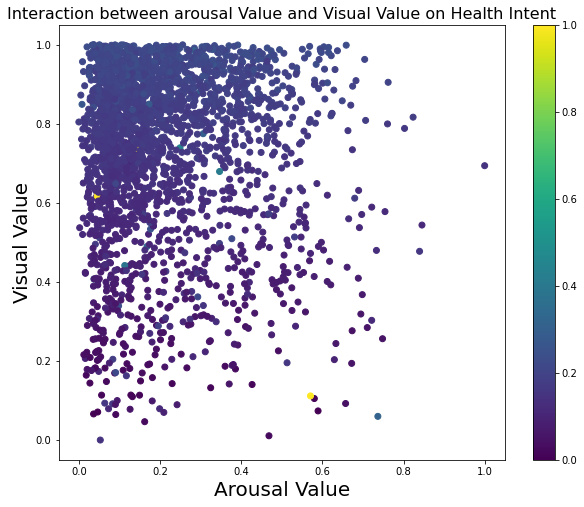

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
# 绘制散点图
plt.scatter(rawdata['arousal'], rawdata['variation'], c=rawdata['intention_counts'])
# 添加图例
plt.colorbar()
# 添加坐标轴标签
plt.xlabel("Arousal Value",size=20)
plt.ylabel("Visual Value",size=20)
# 添加标题
plt.title("Interaction between arousal Value and Visual Value on Health Intent",size=16)
# 显示图像
plt.show()

In [8]:
df.to_csv('1.csv',index=False,encoding='utf_8_sig')

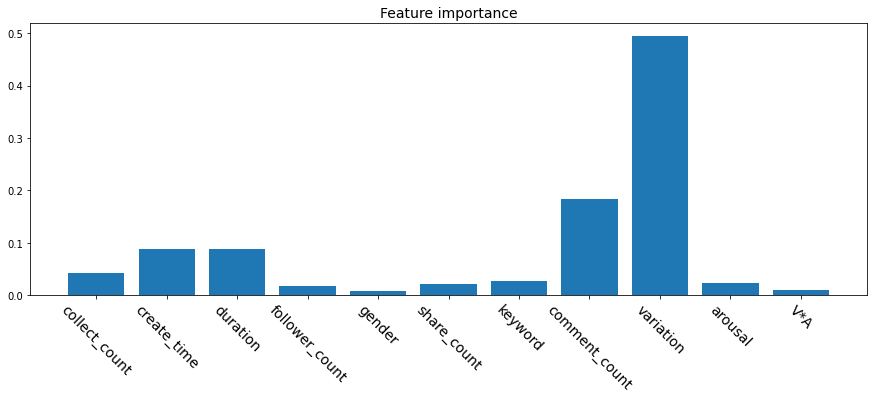

In [9]:
# 获取feature importance
import matplotlib.pyplot as plt
cols=rawdata.iloc[:,:-2].columns
plt.figure(figsize=(15, 5))
plt.bar(range(len(cols)), model.feature_importances_)
plt.xticks(range(len(cols)), cols, rotation=-45, fontsize=14)
plt.title('Feature importance', fontsize=14)
plt.savefig('1.png')
plt.show()

In [10]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(rawdata.iloc[:,:-2][cols])

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


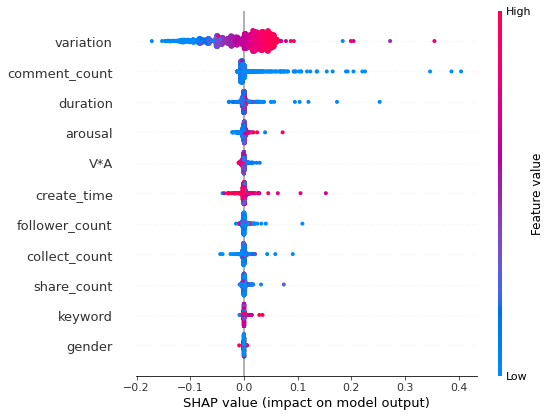

In [11]:
shap.summary_plot(shap_values, rawdata.iloc[:,:-2][cols])

### 分类

In [37]:
rawdata=pd.read_excel("../backup/arousal_record_modify.xlsx")
rawdata=rawdata[['collect_count','create_time','digg_count','duration','follower_count','gender','share_count','keyword','comment_get','comment_count','intention_counts','variation','arousal']]
rawdata=rawdata[rawdata['variation'].notna()]
# rawdata=rawdata.loc[np.load('data_index.npz',allow_pickle=True)['data']]
rawdata=rawdata[rawdata['arousal'].notna()]
def keyword_encode(keyword):
    if "运动" in keyword:
        return 0
    elif "健身" in keyword:
        return 1
    elif "减肥" in keyword:
        return 2
    elif "自律" in keyword:
        return 3
rawdata['keyword']=rawdata['keyword'].apply(keyword_encode) # 非数字编码
rawdata.fillna(0) # 空值填充0
rawdata.drop('comment_get',axis=1)
columns=['collect_count', 'create_time','duration',
       'follower_count', 'gender', 'share_count', 'keyword','comment_count',
        'variation', 'arousal' ,'digg_count', 'intention_counts']
rawdata=rawdata[columns]
rawdata=rawdata.replace('NA',0)
rawdata['intention_counts'][rawdata['intention_counts']==1]=0
rawdata['intention_counts'][rawdata['intention_counts']>1]=1
rawdata=rawdata.dropna()
x=rawdata.iloc[:,:-1]
y=rawdata.iloc[:,-1]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [38]:
scaler = MinMaxScaler() #实例化
x = scaler.fit_transform(x) #fit，在这里本质是生成min(x)和max(x)
x = pd.DataFrame(x)

In [39]:
y.value_counts()

1    3120
0     546
Name: intention_counts, dtype: int64

In [40]:
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.20)
dataset=X_train, y_train, X_test, y_test

BaseLine : XGBoost
Running time: 0.32408785820007324 Seconds


,Positive,Negative,accuracy,macro avg,weighted avg
precision,0.49,0.88,0.85,0.69,0.82
recall,0.27,0.95,0.85,0.61,0.85
f1-score,0.35,0.91,0.85,0.63,0.83
support,110.00,624.00,0.85,734.00,734.00


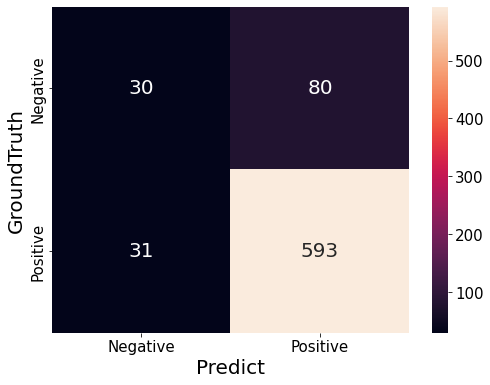

,BaslineName,Accuracy,Precision,MCC,PPV,NPV,Recall,F1,Time,TP,FP,TN,FN
0,XGBoost,0.848774,0.881129,0.288413,0.881129,0.491803,0.950321,0.914418,0.32,593,80,30,31


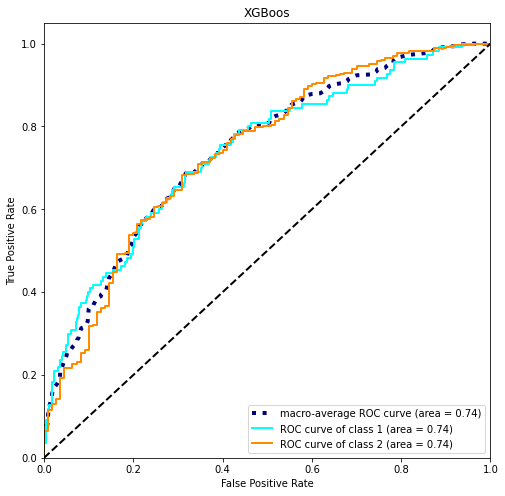

BaseLine : NaiveBayes
Running time: 0.009072303771972656 Seconds


,Positive,Negative,accuracy,macro avg,weighted avg
precision,0.18,0.89,0.49,0.54,0.79
recall,0.70,0.45,0.49,0.58,0.49
f1-score,0.29,0.60,0.49,0.44,0.55
support,110.00,624.00,0.49,734.00,734.00


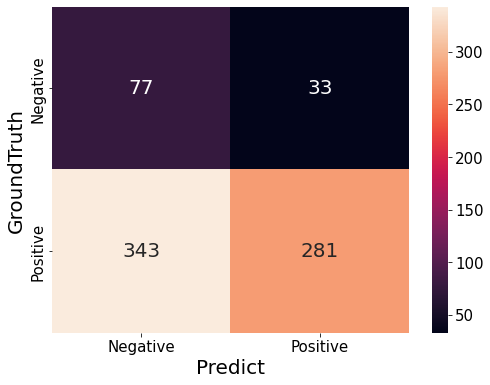

,BaslineName,Accuracy,Precision,MCC,PPV,NPV,Recall,F1,Time,TP,FP,TN,FN
0,NaiveBayes,0.487738,0.894904,0.108447,0.894904,0.183333,0.450321,0.599147,0.01,281,33,77,343


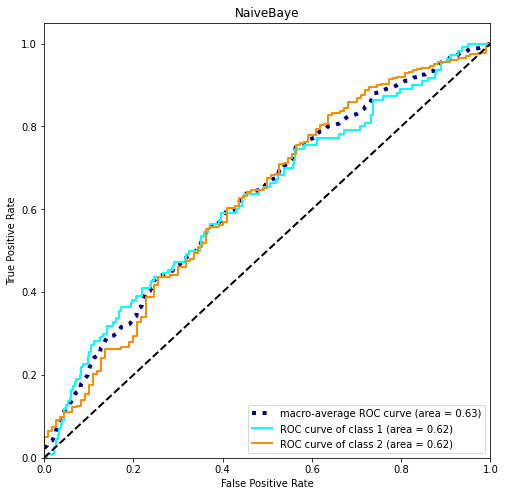

BaseLine : GradientBoosting
Running time: 0.6266160011291504 Seconds


,Positive,Negative,accuracy,macro avg,weighted avg
precision,0.53,0.88,0.85,0.70,0.83
recall,0.25,0.96,0.85,0.60,0.85
f1-score,0.34,0.92,0.85,0.63,0.83
support,110.00,624.00,0.85,734.00,734.00


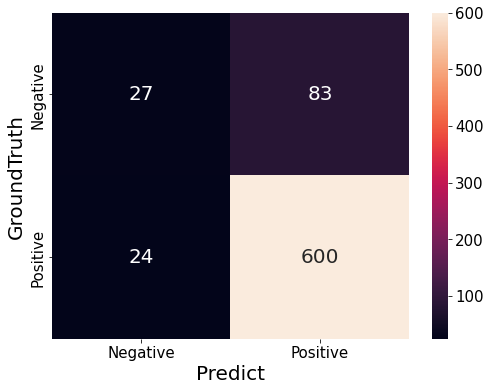

,BaslineName,Accuracy,Precision,MCC,PPV,NPV,Recall,F1,Time,TP,FP,TN,FN
0,GradientBoosting,0.854223,0.878477,0.290569,0.878477,0.529412,0.961538,0.918133,0.63,600,83,27,24


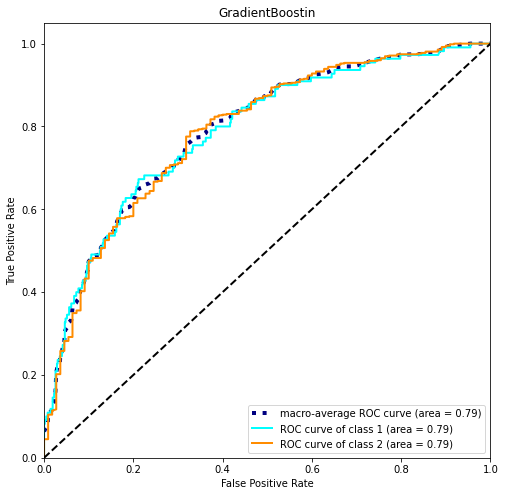

In [41]:
methods=['XGBoost','NaiveBayes','GradientBoosting']
method_compare=[]
label_column=['Positive','Negative']
for method in methods:
    path='save/'+method+'/'
    if not os.path.isdir(path):
        os.makedirs(path)
    print('='*100)
    print('BaseLine : '+method)
    groundtruth, predict, predictprob,item=evaluate(method,dataset)
    method_compare.append(item)
    # 导出报告
    matrix=metrics.confusion_matrix(groundtruth, predict)
    result=pd.DataFrame(matrix,columns=label_column,index=label_column)
    report=classification_report(groundtruth, predict,target_names=label_column,output_dict=True)
    report=round(pd.DataFrame(report).T,2)
    report.T.to_csv(path+'report.csv',encoding='utf_8')
    display(report.T)
    plot_matrix(groundtruth, predict,path+'./confusion_matrix.png')
    display(pd.DataFrame([method_compare[-1]]))
    ROC_plot(y_test,predictprob,path+method)

### 机器模型比对

In [41]:
pd.DataFrame(method_compare)

,BaslineName,Accuracy,Precision,MCC,PPV,NPV,Recall,F1,Time,TP,FP,TN,FN
0,XGBoost,0.852861,0.878698,0.320578,0.878698,0.551724,0.958065,0.916667,0.38,594,82,32,26
1,NaiveBayes,0.521798,0.911315,0.164886,0.911315,0.208845,0.480645,0.629356,0.01,298,29,85,322
2,GradientBoosting,0.861035,0.878655,0.346869,0.878655,0.620000,0.969355,0.921779,0.80,601,83,31,19
